In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("dark")

In [28]:
nd = "nyc_10_15"
norm_data = pd.read_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/norm_data.csv")
gru_wt = pd.read_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/gr_wt.csv")
dijk_wt = pd.read_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/dijk.csv")

In [29]:
norm_data.head()

,Sno,id,delay,jitter,bandwidth
0,1,0,0.014941,0.008373,0.036835
1,2,0,0.041811,0.009483,0.041918
2,130,0,0.049379,0.006231,0.055708
3,3,0,0.034765,0.007857,0.035986
4,4,0,0.060336,0.005097,0.050338


In [80]:
norm_data["weight"] = norm_data["delay"] + norm_data["jitter"]

In [81]:
# mapping the nodes in gru code to openflow controller notation
def map_hex(s):
    if s.isdigit():
        return s
    else:
        return str(ord(s) - ord('a') + 10)

mf = open(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/gru/meta.txt")
mp1 = {}
for i in mf.readlines():
    a,b  = i.split(":")[-2] , i.split(":")[-1]
    mp1[b[:-1]] = a[-1]

mf = open(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/dij/meta.txt")
mp2 = {}

for i in mf.readlines():
    a,b  = i.split(":")[-2] , i.split(":")[-1]
    mp2[b[:-1]] = a[-1]


In [82]:
def normalise(df , pr, is_gru ):
    df = df[[pr, "Sno"]].groupby("Sno").mean()

    df.reset_index(level=0, inplace=True)
    
    mp = {}
    if is_gru: mp = mp1
    else: mp = mp2

    df["link"] = df["Sno"].apply( lambda x : map_hex(mp[str(x//14)])  + "-" + map_hex(mp[str(x%14)]) )
    return df

In [83]:
gru_wts = normalise(norm_data , "weight" , True)
gru_delay = normalise(gru_wt , "delay", True )
gru_delay.rename(columns = {'delay':'gru_delay'}, inplace = True)
dij_delay = normalise(dijk_wt , "delay", False )
dij_delay.rename(columns = {'delay':'dij_delay'}, inplace = True)

In [84]:
link_stats = gru_delay[["gru_delay" , "link"] ].copy()
link_stats = link_stats.merge( gru_wts[["weight" , "link"]] , on="link" )
link_stats = link_stats.merge( dij_delay[["dij_delay" , "link"]] , on="link" )
link_stats.sort_values("link")
link_stats.to_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/weight_anal/LinkStats.csv")

In [5]:
link_stats= pd.read_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/weight_anal/LinkStats.csv")
link_stats = link_stats.sort_values("link")

In [11]:
ds = pd.melt(link_stats[["weight" ,"gru_delay" , "dij_delay" , "link"]], id_vars=["link" , "weight"  ], var_name="delay_type", value_name="value")
ds = ds.sort_values("link")
ds.head()

,link,weight,delay_type,value
0,1-11,0.009731,gru_delay,481.990323
58,1-11,0.009731,dij_delay,479.375806
1,1-3,0.014826,gru_delay,779.214516
59,1-3,0.014826,dij_delay,38007.190275
2,1-4,0.020231,gru_delay,1237.924194


<AxesSubplot: xlabel='link', ylabel='weight'>

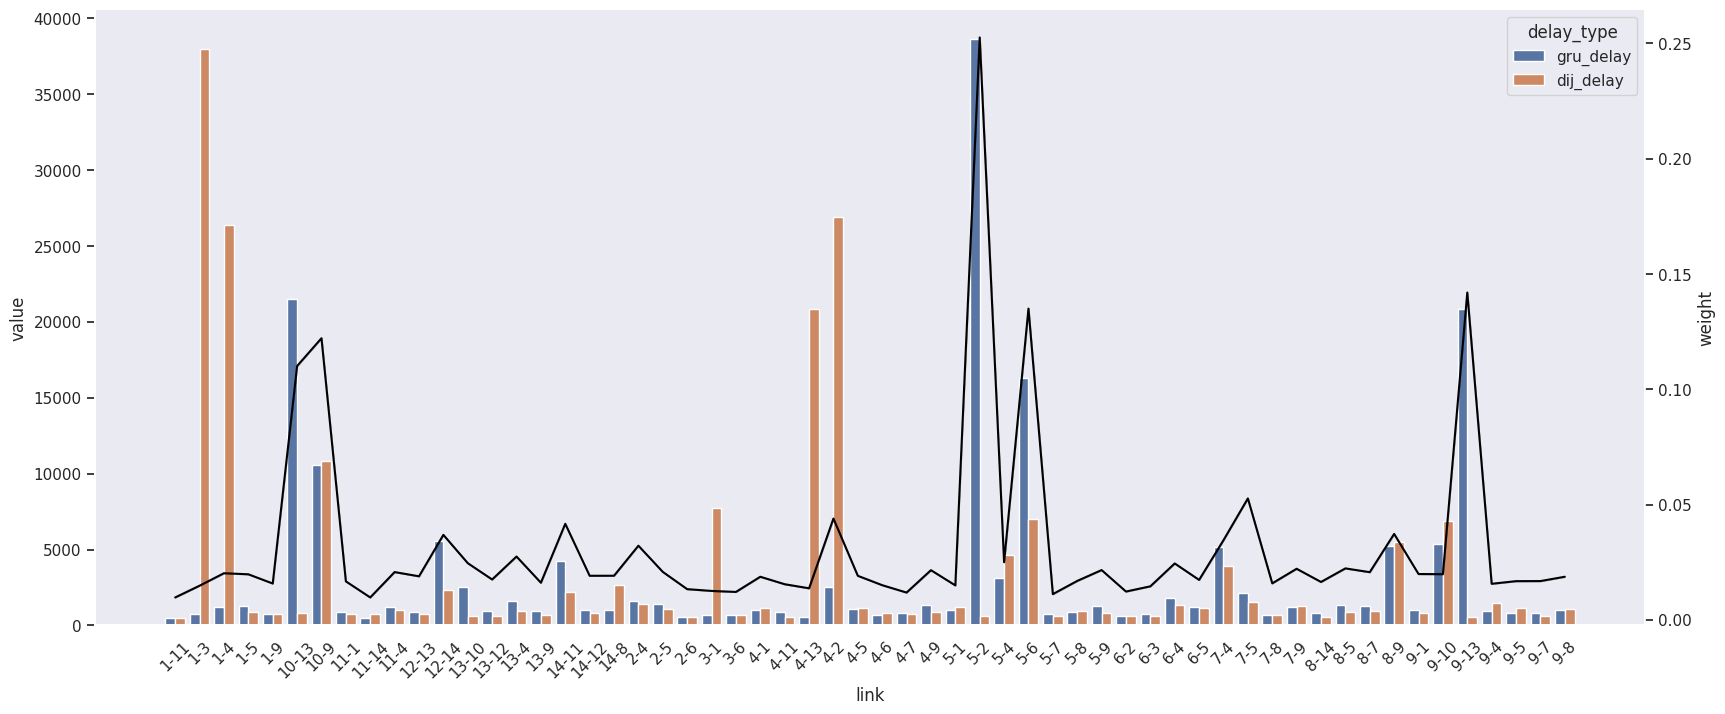

In [12]:
plt.xticks(rotation=45)
sns.barplot(x="link" , y="value", hue="delay_type",data= ds)
ax2=plt.twinx()
sns.lineplot(x="link" , y="weight", color="black" , data = ds)

[Text(0, 0.5, 'delay'),
 Text(0.5, 1.0, 'GRU and Dijkstras weight and delay vs link')]

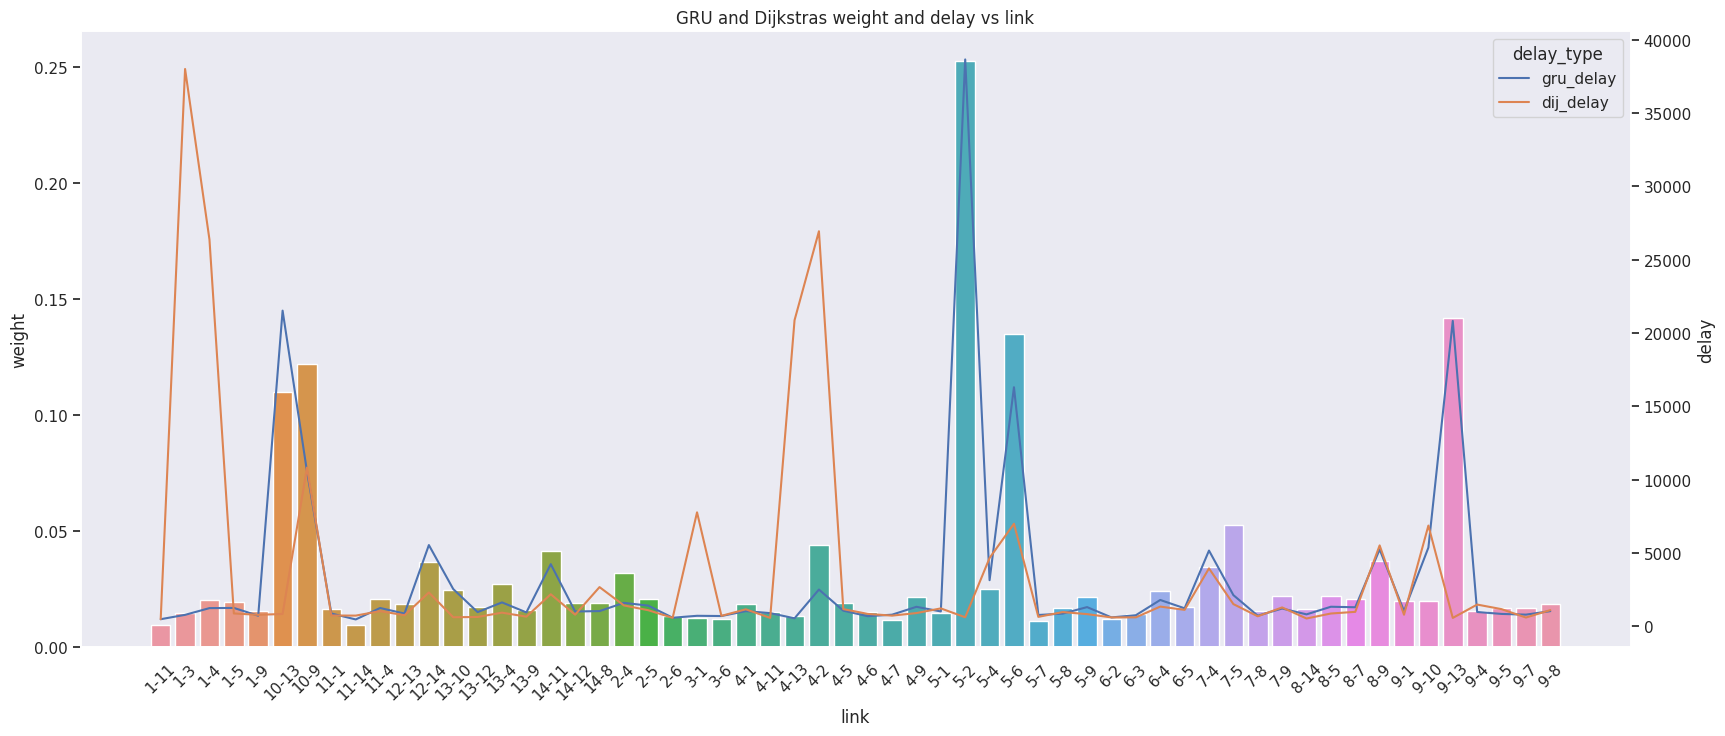

In [26]:
plt.xticks(rotation=45)
sns.barplot(x="link" , y="weight",  data = link_stats)
ax2=plt.twinx()
# sns.lineplot(x="link" , y="dij_delay" , color="#34495e",data= link_stats)
sns.lineplot(x="link" , y="value" , hue="delay_type", data= ds).set(ylabel="delay" , title="GRU and Dijkstras weight and delay vs link")


In [46]:
class floyd_warshall:
    def __init__(self , n):
        self.n = n
        self.adj = [[-1 for i in range(n)] for j in range(n)]
        self.dl = [[-1 for i in range(n)] for j in range(n)]
        self.prv = [[-1 for i in range(n)] for j in range(n)]
        self.cost = [[-1 for i in range(n)] for j in range(n)]
        self.dl_cost = [[-1 for i in range(n)] for j in range(n)]
    
    def add_edge(self, i , j , wt, dl ):
        self.adj[i][j] = wt
        self.cost[i][j] = wt
        self.dl[i][j] = dl
        self.dl_cost[i][j] = dl
        self.prv[i][j] = j
    
    def calculate(self):
        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    if (self.adj[i][k] == -1 or self.adj[k][j] == -1):
                        continue
                    
                    if (self.adj[i][j] > self.adj[i][k] + self.adj[k][j] or self.adj[i][j] == -1):
                        self.adj[i][j] = self.adj[i][k] + self.adj[k][j]
                        self.dl[i][j] = self.dl[i][k] + self.dl[k][j]
                        self.prv[i][j] = self.prv[i][k]

    def constructPath(self, u, v):
        if (self.prv[u][v] == -1):
            return {}
    
        path = [u]
        while (u != v):
            u = self.prv[u][v]
            path.append(u)

        return path

In [47]:
norm_data

,Sno,id,delay,jitter,bandwidth,weight
0,1,0,0.014941,0.008373,0.036835,0.023314
1,2,0,0.041811,0.009483,0.041918,0.051294
2,130,0,0.049379,0.006231,0.055708,0.055610
3,3,0,0.034765,0.007857,0.035986,0.042622
4,4,0,0.060336,0.005097,0.050338,0.065433
...,...,...,...,...,...,...
3591,107,61,0.011309,0.015574,0.000008,0.026883
3592,114,61,0.020686,0.026409,0.000009,0.047094
3593,116,61,0.030092,0.029009,0.000009,0.059101
3594,117,61,0.044367,0.045712,0.000009,0.090079


In [48]:
def conv_ind(sno , is_gru):
    x,y = sno//14 , sno%14
    
    mp = {}
    if is_gru: mp = mp1
    else: mp = mp2
    x = int(map_hex(mp[str(x)])) - 1
    y = int(map_hex(mp[str(y)])) - 1
    return x , y

In [49]:
gr = floyd_warshall(14)
for j in dijk_wt[dijk_wt["id"] == 0].itertuples():
    x,y = conv_ind(j[1] , False)
    gr.add_edge(x, y , 1 , 0)


gr.calculate()

pths = []
dl_mat = []
wt_mat = []
cost_d_mat = []
cost_mat = []

pths.append(gr.prv)
dl_mat.append(gr.dl)
wt_mat.append(gr.adj)
cost_mat.append(gr.cost)
cost_d_mat.append(gr.dl_cost)

for i in range(norm_data["id"].max() + 1):
    gr = floyd_warshall(14)
    
    for j in norm_data[norm_data["id"] == i].itertuples():
        x, y = conv_ind(j[1] , True)
        gr.add_edge(x, y , j[6] , float(gru_wt[(gru_wt["id"] == i )& (gru_wt["Sno"] == j[1])]["delay"]) )

    gr.calculate()

    pths.append(gr.prv)
    wt_mat.append(gr.adj)
    dl_mat.append(gr.dl)
    cost_mat.append(gr.cost)
    cost_d_mat.append(gr.dl_cost)

pths = np.array(pths)
dl_mat = np.array(dl_mat)
wt_mat = np.array(wt_mat)
cost_mat = np.array(cost_mat)
cost_d_mat = np.array(cost_d_mat)

pths.shape , dl_mat.shape, wt_mat.shape , cost_mat.shape , cost_d_mat.shape

((63, 14, 14), (63, 14, 14), (63, 14, 14), (63, 14, 14), (63, 14, 14))

In [50]:
df_next_hop = pd.DataFrame({"link" :[] , "next_hop":[] , "iter" : [] , "wt" : [] , "delay" : [] } )

for i in range(14):
    for j in range(14):
        for x in range(pths.shape[0]):
            df1 = {}
            df1["link"] = str(i+1) + "-" + str(j+1)
            df1["next_hop"] = str(pths[x,i,j] + 1)
            df1["iter"] = int(0)
            df1["wt"] = str(wt_mat[x,i,j])
            df1["delay"] = str(dl_mat[x,i,j])
            df_next_hop = pd.concat([df_next_hop, pd.DataFrame(df1, index=[0])])

df_next_hop.head()

,link,next_hop,iter,wt,delay
0,1-1,3,0.0,2.0,0.0
0,1-1,9,0.0,0.060214462399999995,713.3
0,1-1,11,0.0,0.0823217185,215.39999999999998
0,1-1,3,0.0,0.077243056,593.0
0,1-1,11,0.0,0.0269231124,149.5


In [51]:
df_next_hop.to_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/weight_anal/next.csv", index=False)

In [31]:
x , y = 5 , 12

In [63]:
df_link = {}
df_link["Iteration"] = list(range(63))
df_link["next_hop"] = pths[:,x,y] + 1
df_link["weight"] = wt_mat[:,x,y]
df_link["delay"] = dl_mat[:,x,y]
df_link["delay_lnk"] = cost_d_mat[:,x,y]
df_link["weight"][0] = 0
df_link = pd.DataFrame(df_link)
df_link.head()

df_link.to_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/weight_anal/{x+1}-{y+1}-LinkData.csv")

In [34]:
df_link = pd.read_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/weight_anal/{x+1}-{y+1}-LinkData.csv")
df_link["next_hop"] += 1

[Text(0.5, 1.0, '6-13 Link')]

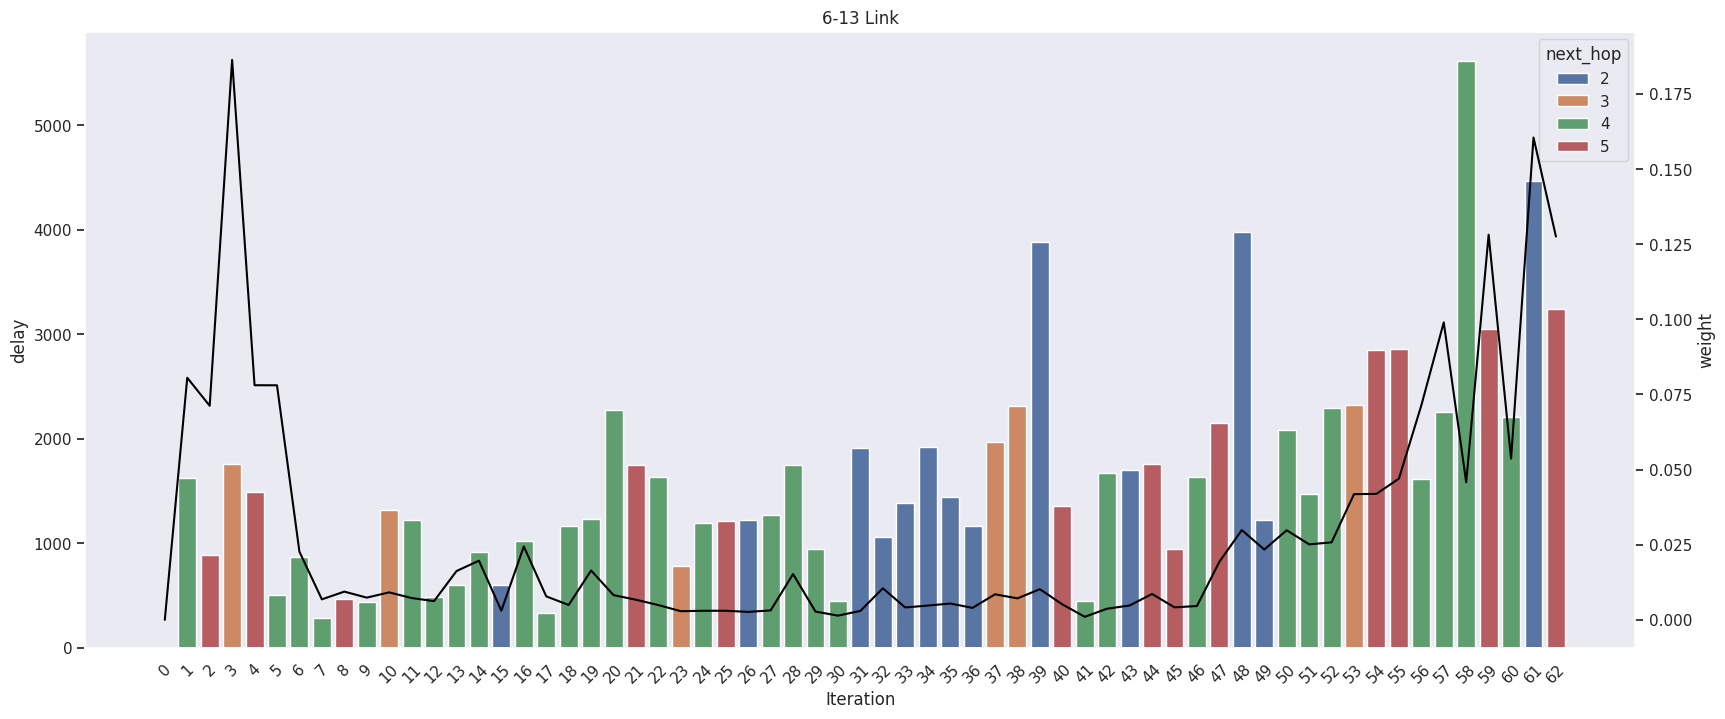

In [35]:
fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
sns.barplot(x="Iteration" , hue="next_hop" , y="delay", data =df_link , dodge=False).set(ylabel="delay")
ax2 = plt.twinx()
sns.lineplot(x="Iteration" , y="weight" , color="black", data =df_link , ax=ax2 ).set(title=f"{x+1}-{y+1} Link")

In [65]:
df = pd.DataFrame({"cost" : [] , "path" : [] , "indv_costs" : [], "path_cost" : []})

for i in range(62):
    gr = floyd_warshall(14)
    gr.prv = pths[i]
    ds = {}
    ar = gr.constructPath(x,y)
    costs = []

    ds["cost"] = cost_mat[i,x,y]
    ds["path"] = str([ i + 1 for i in ar ])[1:-1]

    for j in range(len(ar)-1):
        costs.append( cost_mat[i,ar[j] , ar[j+1] ] )

    ds["indv_costs"] = str(costs)[1:-1]
    ds["path_cost"] = sum(costs)

    df = pd.concat([df, pd.DataFrame(ds, index=[0])])

df.head()

,cost,path,indv_costs,path_cost
0,-1.0,"6, 4, 13","1.0, 1.0",2.000000
0,-1.0,"6, 4, 13","0.06543289149999999, 0.2606755",0.326108
0,-1.0,"6, 4, 13","0.058946986, 0.05092564",0.109873
0,-1.0,"6, 4, 9, 10, 13","0.07034104699999999, 0.009872635099999999, 0.0...",0.122158
0,-1.0,"6, 4, 13","0.052387419, 0.078121055",0.130508


In [66]:
df.to_csv(f"/home/manoj/sdn/onos-apps/network_data/test/{nd}/weight_anal/{x+1}-{y+1}-LinkPaths.csv")
df["path"].value_counts()

6, 4, 13                     13
6, 4, 9, 13                  11
6, 5, 9, 13                   8
6, 2, 4, 13                   3
6, 2, 5, 9, 13                3
6, 2, 4, 9, 13                2
6, 2, 5, 1, 9, 13             2
6, 4, 7, 9, 10, 13            2
6, 3, 1, 9, 10, 13            2
6, 5, 1, 9, 13                1
6, 5, 4, 13                   1
6, 2, 4, 9, 10, 13            1
6, 5, 4, 9, 13                1
6, 2, 5, 9, 10, 13            1
6, 2, 5, 8, 14, 12, 13        1
6, 2, 5, 4, 9, 13             1
6, 4, 7, 9, 13                1
6, 4, 5, 9, 10, 13            1
6, 4, 11, 14, 12, 13          1
6, 2, 5, 8, 9, 13             1
6, 4, 9, 10, 13               1
6, 3, 1, 5, 8, 14, 12, 13     1
6, 3, 1, 11, 14, 12, 13       1
6, 3, 1, 9, 13                1
6, 5, 7, 9, 13                1
Name: path, dtype: int64